In [26]:
#NBA Player Turnover Analysis

#This notebook investigates NBA player statistics with a focus on turnovers to uncover patterns and trends that can help evaluate decision making, usage,
#and risk taking tendencies. By analyzing turnovers in context with other performance metrics, we aim to better understand how player roles and playing 
#time influence ball control and overall efficiency.

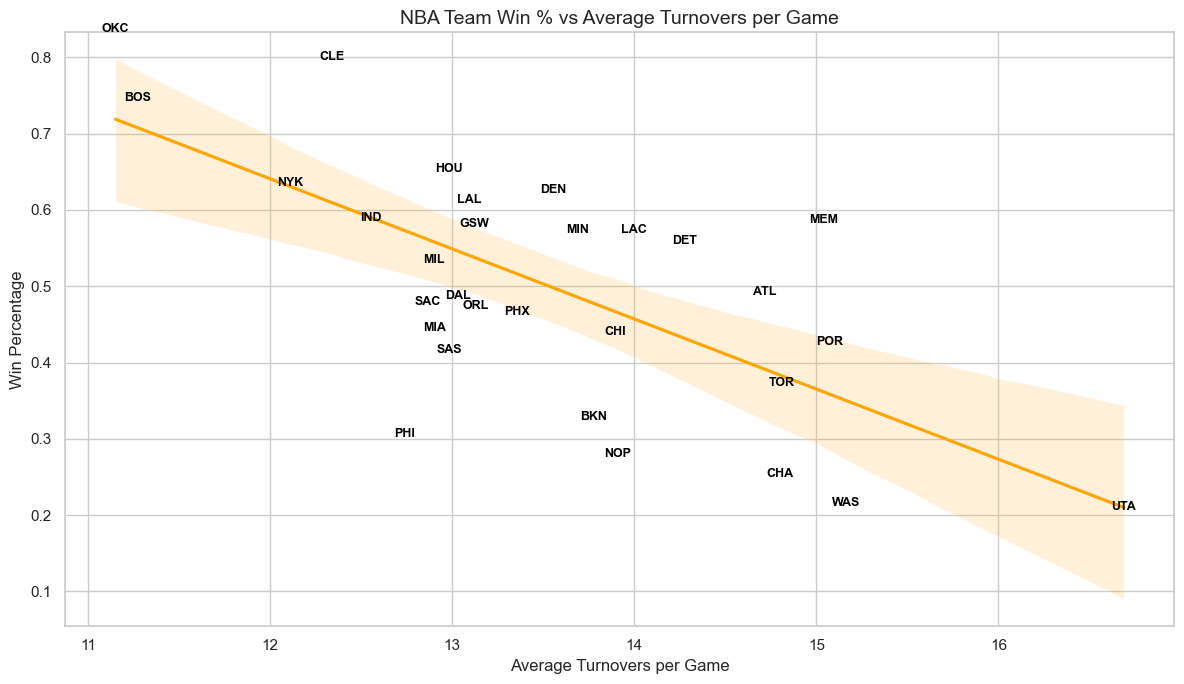

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned NBA season data
df = pd.read_csv("reg_season_24_25_final.xls")

# Compute Win Percentage
home_wins = df[df['HOME_WL'] == 'W'].groupby('HOME_TEAM').size()
away_wins = df[df['VISITOR_WL'] == 'W'].groupby('VISITOR_TEAM').size()
total_wins = home_wins.add(away_wins, fill_value=0)

home_games = df['HOME_TEAM'].value_counts()
away_games = df['VISITOR_TEAM'].value_counts()
total_games = home_games.add(away_games, fill_value=0)

win_pct = (total_wins / total_games).sort_index()

# Compute Average Turnovers 
home_tov = df.groupby('HOME_TEAM')['HOME_TOV'].mean()
visitor_tov = df.groupby('VISITOR_TEAM')['VISITOR_TOV'].mean()
avg_tov = pd.concat([home_tov, visitor_tov], axis=1).mean(axis=1).sort_index()

# Combine into a single DataFrame
eda_df = pd.DataFrame({
    'Team': win_pct.index,
    'Win_Pct': win_pct.values,
    'Avg_Turnovers': avg_tov.values
}).dropna()

# Add 3-letter team abbreviations from HOME_ABBR
team_abbr_map = df[['HOME_TEAM', 'HOME_ABBR']].drop_duplicates().set_index('HOME_TEAM')['HOME_ABBR']
eda_df['Abbr'] = eda_df['Team'].map(team_abbr_map)

# Plot w/ Only team labels
fig, ax = plt.subplots(figsize=(12, 7))
sns.regplot(data=eda_df, x='Avg_Turnovers', y='Win_Pct', scatter=False, ax=ax, color='orange')

# Add team abbreviations as point labels
for _, row in eda_df.iterrows():
    ax.text(row['Avg_Turnovers'], row['Win_Pct'], row['Abbr'],
            fontsize=9, ha='center', va='center', color='black', fontweight='bold')

ax.set_title("NBA Team Win % vs Average Turnovers per Game", fontsize=14)
ax.set_xlabel("Average Turnovers per Game")
ax.set_ylabel("Win Percentage")
plt.tight_layout()
plt.show()



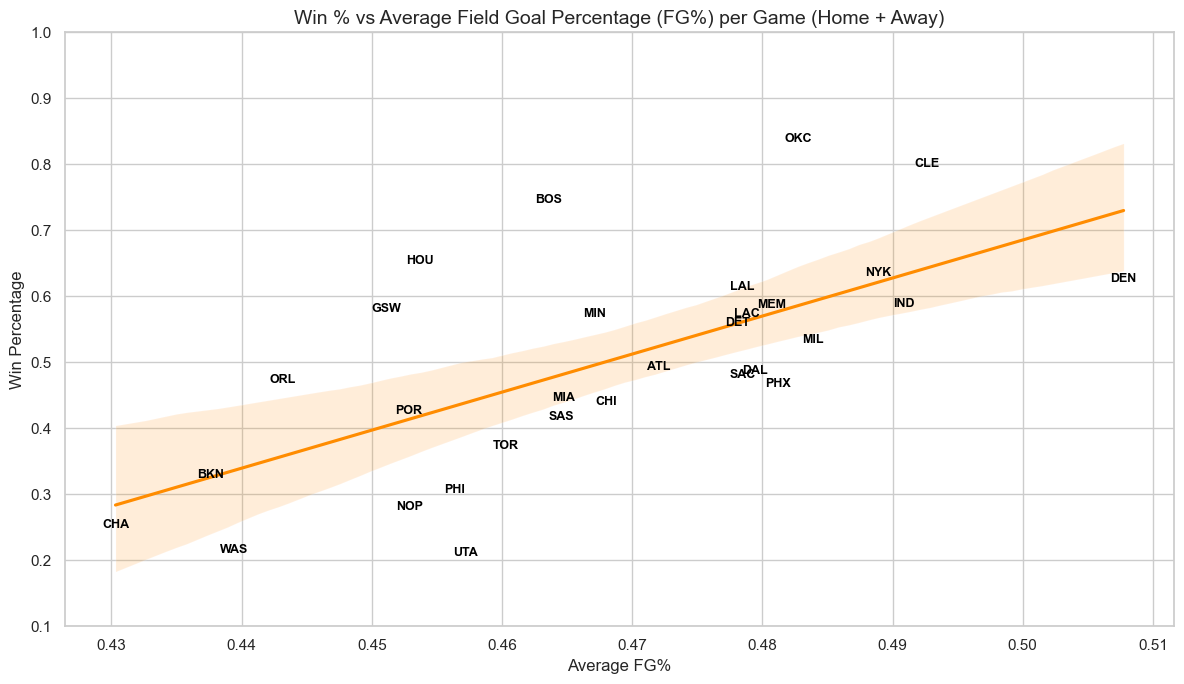

In [28]:
home_fg_df = df[['GAME_ID', 'HOME_TEAM', 'HOME_FG_PCT']].copy()
home_fg_df.columns = ['GAME_ID', 'TEAM', 'FG_PCT']

visitor_fg_df = df[['GAME_ID', 'VISITOR_TEAM', 'VISITOR_FG_PCT']].copy()
visitor_fg_df.columns = ['GAME_ID', 'TEAM', 'FG_PCT']

# Combine both into a single dataframe
combined_fg_df = pd.concat([home_fg_df, visitor_fg_df], ignore_index=True)

# Calculate average FG% per team across all games
avg_fg_pct_per_team = combined_fg_df.groupby('TEAM')['FG_PCT'].mean()

# Calculate overall win percentage per team
total_wins = df[df['HOME_WL'] == 'W'].groupby('HOME_TEAM').size().add(
    df[df['VISITOR_WL'] == 'W'].groupby('VISITOR_TEAM').size(), fill_value=0
)
total_games = df['HOME_TEAM'].value_counts().add(df['VISITOR_TEAM'].value_counts(), fill_value=0)
total_win_pct = (total_wins / total_games).sort_index()

# Combine into one dataframe
combined_fg_stats_df = pd.DataFrame({
    'Avg_FG_PCT': avg_fg_pct_per_team,
    'Win_Pct': total_win_pct
}).dropna()

abbr_map_all = df[['HOME_TEAM', 'HOME_ABBR']].drop_duplicates().set_index('HOME_TEAM')['HOME_ABBR']
combined_fg_stats_df['Abbr'] = combined_fg_stats_df.index.map(abbr_map_all)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))
sns.regplot(data=combined_fg_stats_df, x='Avg_FG_PCT', y='Win_Pct', scatter=False, ax=ax, color='darkorange')

# Add team abbreviation labels
for _, row in combined_fg_stats_df.iterrows():
    ax.text(row['Avg_FG_PCT'], row['Win_Pct'], row['Abbr'],
            fontsize=9, ha='center', va='center', color='black', fontweight='bold')

ax.set_title("Win % vs Average Field Goal Percentage (FG%) per Game (Home + Away)", fontsize=14)
ax.set_xlabel("Average FG%")
ax.set_ylabel("Win Percentage")
ax.set_ylim(0.1, 1.0)
plt.tight_layout()
plt.show()

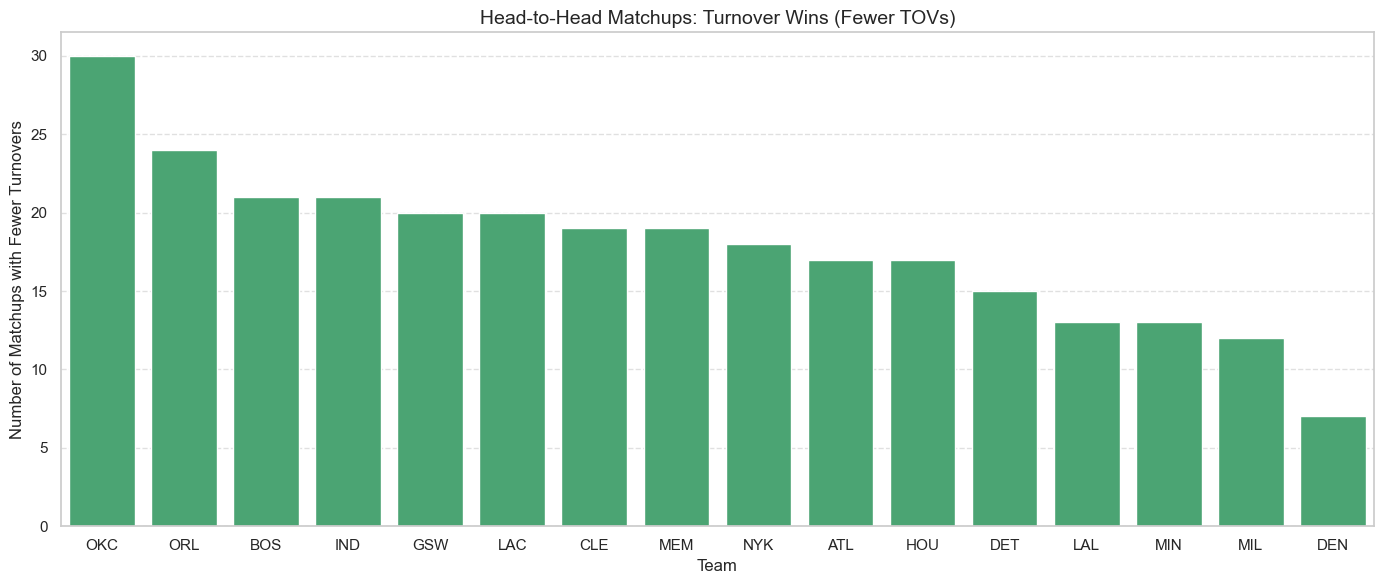

In [29]:
top_eight = [
    'Cleveland Cavaliers', 'Boston Celtics', 'New York Knicks', 'Indiana Pacers',
    'Detroit Pistons', 'Milwaukee Bucks', 'Orlando Magic', 'Atlanta Hawks',
    'Oklahoma City Thunder', 'Houston Rockets', 'Denver Nuggets', 'Los Angeles Lakers',
    'Golden State Warriors', 'Memphis Grizzlies', 'Minnesota Timberwolves', 'LA Clippers'
]

# Filter to games where both teams are in the selected list
head_to_head_df = df[
    (df['HOME_TEAM'].isin(top_eight)) & (df['VISITOR_TEAM'].isin(top_eight))
].copy()

# Determine which team had fewer turnovers
def determine_winner(row):
    if row['HOME_TOV'] < row['VISITOR_TOV']:
        return row['HOME_TEAM']
    elif row['VISITOR_TOV'] < row['HOME_TOV']:
        return row['VISITOR_TEAM']

head_to_head_df['Lower_TOV_Team'] = head_to_head_df.apply(determine_winner, axis=1)

# Count the number of times a team had less turnovers than the other
tov_wins = head_to_head_df['Lower_TOV_Team'].value_counts()
tov_wins = tov_wins.reindex(top_eight, fill_value=0)

# Prepare DataFrame for plotting
tov_head_to_head_summary = pd.DataFrame({
    'Team': tov_wins.index,
    'TOV_HeadToHead_Wins': tov_wins.values
}).sort_values(by='TOV_HeadToHead_Wins', ascending=False)

# Map full team names to abbreviations
abbr_map = df[['HOME_TEAM', 'HOME_ABBR']].drop_duplicates().set_index('HOME_TEAM')['HOME_ABBR']
tov_head_to_head_summary['Abbr'] = tov_head_to_head_summary['Team'].map(abbr_map)

# Plot the bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=tov_head_to_head_summary, x='Abbr', y='TOV_HeadToHead_Wins', color='mediumseagreen')

plt.title("Head-to-Head Matchups: Turnover Wins (Fewer TOVs)", fontsize=14)
plt.xlabel("Team")
plt.ylabel("Number of Matchups with Fewer Turnovers")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

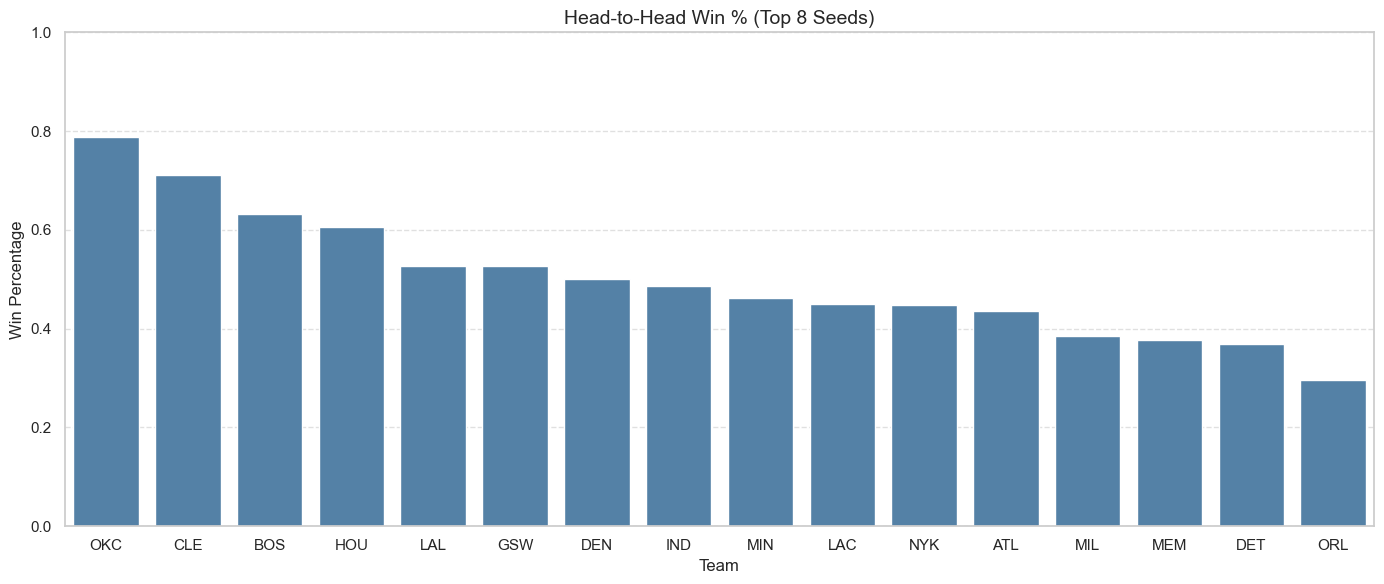

In [30]:
# Selected teams (full names)
top_eight = [
    'Cleveland Cavaliers', 'Boston Celtics', 'New York Knicks', 'Indiana Pacers',
    'Detroit Pistons', 'Milwaukee Bucks', 'Orlando Magic', 'Atlanta Hawks',
    'Oklahoma City Thunder', 'Houston Rockets', 'Denver Nuggets', 'Los Angeles Lakers',
    'Golden State Warriors', 'Memphis Grizzlies', 'Minnesota Timberwolves', 'LA Clippers'
]

# Filter to games where both teams are in the selected list
head_to_head_df = df[
    (df['HOME_TEAM'].isin(top_eight)) & (df['VISITOR_TEAM'].isin(top_eight))
].copy()

# Determine the game winner
def game_winner(row):
    if row['HOME_WL'] == 'W':
        return row['HOME_TEAM']
    elif row['VISITOR_WL'] == 'W':
        return row['VISITOR_TEAM']

head_to_head_df['Game_Winner'] = head_to_head_df.apply(game_winner, axis=1)

# Count number of wins per team
head_to_head_win_counts = head_to_head_df['Game_Winner'].value_counts()
head_to_head_win_counts = head_to_head_win_counts.reindex(top_eight, fill_value=0)

# Count number of games played by each team
home_counts = head_to_head_df['HOME_TEAM'].value_counts()
visitor_counts = head_to_head_df['VISITOR_TEAM'].value_counts()
total_games_played = home_counts.add(visitor_counts, fill_value=0)
total_games_played = total_games_played.reindex(top_eight, fill_value=0)

# Calculate win percentage
head_to_head_win_pct = (head_to_head_win_counts / total_games_played).fillna(0).sort_values(ascending=False)

# Create DataFrame for plotting
head_to_head_win_pct_df = pd.DataFrame({
    'Team': head_to_head_win_pct.index,
    'Win_Pct_in_HeadToHead': head_to_head_win_pct.values.round(3)
})

# Map full team names to abbreviations
abbr_map = df[['HOME_TEAM', 'HOME_ABBR']].drop_duplicates().set_index('HOME_TEAM')['HOME_ABBR']
head_to_head_win_pct_df['Abbr'] = head_to_head_win_pct_df['Team'].map(abbr_map)

# Plot
plot_df_win_pct = head_to_head_win_pct_df.sort_values(by='Win_Pct_in_HeadToHead', ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df_win_pct, x='Abbr', y='Win_Pct_in_HeadToHead', color='steelblue')

plt.title("Head-to-Head Win % (Top 8 Seeds)", fontsize=14)
plt.xlabel("Team")
plt.ylabel("Win Percentage")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


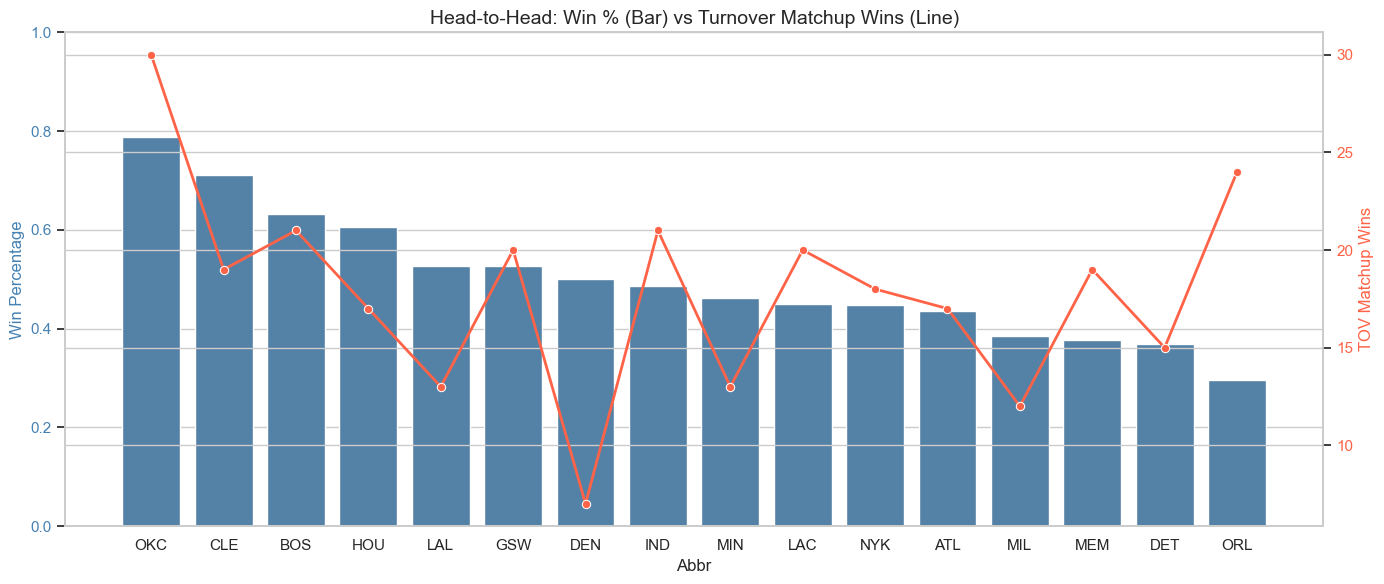

In [32]:
top_eight = [
    'Cleveland Cavaliers', 'Boston Celtics', 'New York Knicks', 'Indiana Pacers',
    'Detroit Pistons', 'Milwaukee Bucks', 'Orlando Magic', 'Atlanta Hawks',
    'Oklahoma City Thunder', 'Houston Rockets', 'Denver Nuggets', 'Los Angeles Lakers',
    'Golden State Warriors', 'Memphis Grizzlies', 'Minnesota Timberwolves', 'LA Clippers'
]

# Filter to head-to-head games between selected teams
head_to_head_df = df[
    (df['HOME_TEAM'].isin(top_eight)) & (df['VISITOR_TEAM'].isin(top_eight))
].copy()

# WINNER: Determine game winner
def game_winner(row):
    if row['HOME_WL'] == 'W':
        return row['HOME_TEAM']
    elif row['VISITOR_WL'] == 'W':
        return row['VISITOR_TEAM']

head_to_head_df['Game_Winner'] = head_to_head_df.apply(game_winner, axis=1)

# Count wins and total games played
win_counts = head_to_head_df['Game_Winner'].value_counts().reindex(top_eight, fill_value=0)
home_counts = head_to_head_df['HOME_TEAM'].value_counts()
visitor_counts = head_to_head_df['VISITOR_TEAM'].value_counts()
games_played = home_counts.add(visitor_counts, fill_value=0).reindex(top_eight, fill_value=0)
win_pct = (win_counts / games_played).fillna(0).sort_values(ascending=False)

# Format win % DataFrame
win_pct_df = pd.DataFrame({
    'Team': win_pct.index,
    'Win_Pct_in_HeadToHead': win_pct.values.round(3)
})

# TURNOVER WINS: Determine lower turnover team per game
def lower_tov(row):
    if row['HOME_TOV'] < row['VISITOR_TOV']:
        return row['HOME_TEAM']
    elif row['VISITOR_TOV'] < row['HOME_TOV']:
        return row['VISITOR_TEAM']

head_to_head_df['Lower_TOV_Team'] = head_to_head_df.apply(lower_tov, axis=1)
tov_wins = head_to_head_df['Lower_TOV_Team'].value_counts().reindex(top_eight, fill_value=0)

# Map full names to abbreviations
abbr_map = df[['HOME_TEAM', 'HOME_ABBR']].drop_duplicates().set_index('HOME_TEAM')['HOME_ABBR']

# Combine both win % and TOV wins
combined_df = pd.merge(
    win_pct_df,
    pd.DataFrame({'Team': tov_wins.index, 'TOV_HeadToHead_Wins': tov_wins.values}),
    on='Team'
)
combined_df['Abbr'] = combined_df['Team'].map(abbr_map)
combined_df = combined_df.sort_values(by='Win_Pct_in_HeadToHead', ascending=False)

# Plot: Bar for Win %, Line for TOV Wins
fig, ax1 = plt.subplots(figsize=(14, 6))


# Bar plot (Win %)
sns.barplot(data=combined_df, x='Abbr', y='Win_Pct_in_HeadToHead', ax=ax1, color='steelblue')
ax1.set_ylabel('Win Percentage', color='steelblue')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
sns.lineplot(data=combined_df, x='Abbr', y='TOV_HeadToHead_Wins', ax=ax2, color='tomato', marker='o', linewidth=2)
ax2.set_ylabel('TOV Matchup Wins', color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title("Head-to-Head: Win % (Bar) vs Turnover Matchup Wins (Line)", fontsize=14)
plt.xlabel("Team")
plt.tight_layout()
plt.show()

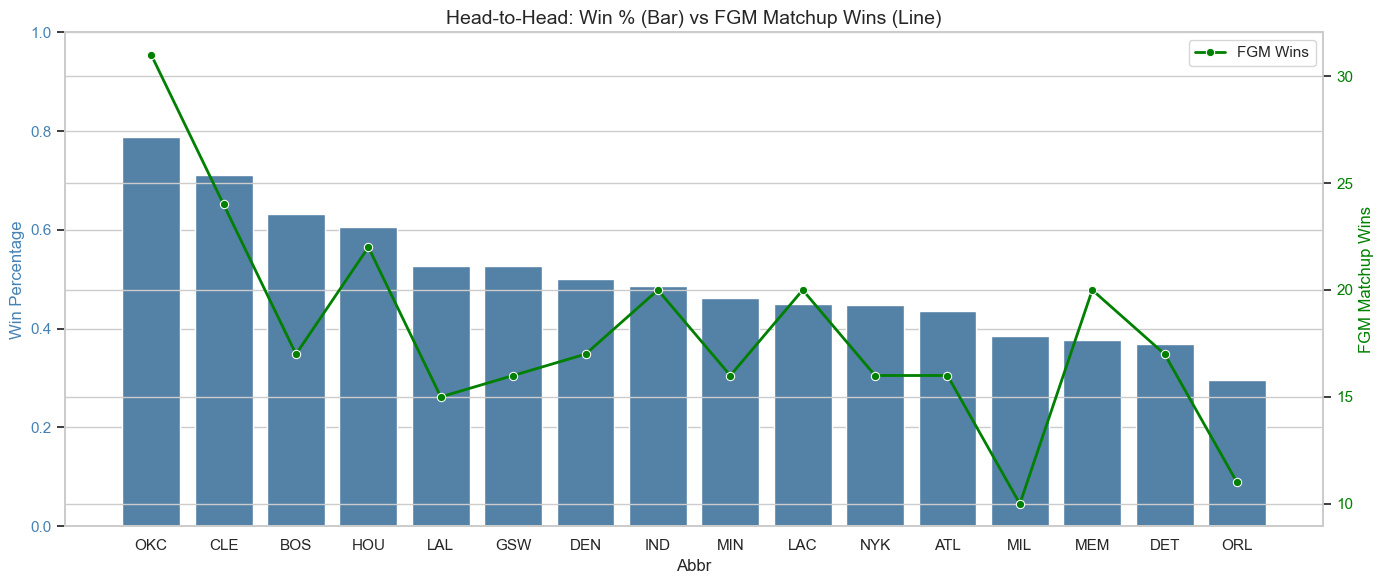

In [33]:
def fgm_winner(row):
    if row['HOME_FGM'] > row['VISITOR_FGM']:
        return row['HOME_TEAM']
    elif row['VISITOR_FGM'] > row['HOME_FGM']:
        return row['VISITOR_TEAM']

# Apply to head-to-head dataframe
head_to_head_df['FGM_Winner'] = head_to_head_df.apply(fgm_winner, axis=1)

# Count FGM wins per team
fgm_wins = head_to_head_df['FGM_Winner'].value_counts().reindex(top_eight, fill_value=0)

# Merge with win percentage data
fgm_df = pd.merge(
    win_pct_df,
    pd.DataFrame({'Team': fgm_wins.index, 'FGM_Wins': fgm_wins.values}),
    on='Team'
)
fgm_df['Abbr'] = fgm_df['Team'].map(abbr_map)
fgm_df = fgm_df.sort_values(by='Win_Pct_in_HeadToHead', ascending=False)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart for win %
sns.barplot(data=fgm_df, x='Abbr', y='Win_Pct_in_HeadToHead', ax=ax1, color='steelblue')
ax1.set_ylabel('Win Percentage', color='steelblue')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Line chart for FGM wins
ax2 = ax1.twinx()
sns.lineplot(data=fgm_df, x='Abbr', y='FGM_Wins', ax=ax2, color='green', marker='o', linewidth=2, label='FGM Wins')
ax2.set_ylabel('FGM Matchup Wins', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Head-to-Head: Win % (Bar) vs FGM Matchup Wins (Line)", fontsize=14)
plt.xlabel("Team")
plt.tight_layout()
plt.show()

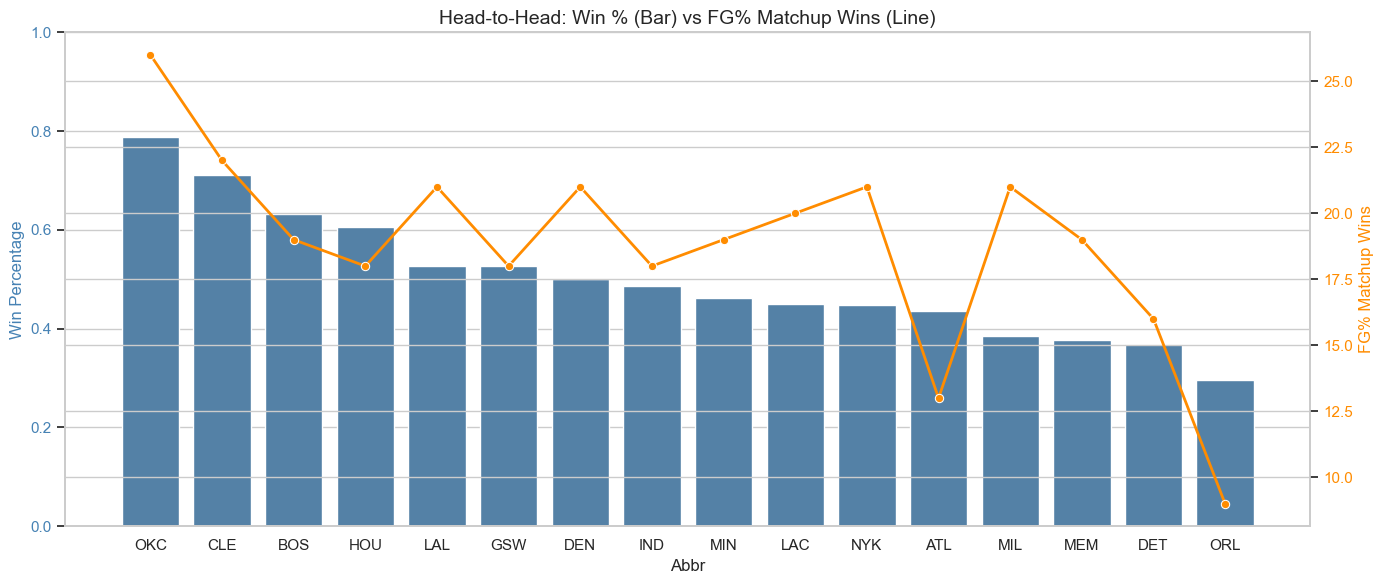

In [18]:
def fg_winner(row):
    if row['HOME_FG_PCT'] > row['VISITOR_FG_PCT']:
        return row['HOME_TEAM']
    elif row['VISITOR_FG_PCT'] > row['HOME_FG_PCT']:
        return row['VISITOR_TEAM']

head_to_head_df['FGP_Winner'] = head_to_head_df.apply(fg_winner, axis=1)

# Count how many times each team had the higher FG%
fgp_wins = head_to_head_df['FGP_Winner'].value_counts().reindex(top_eight, fill_value=0)

# Merge with win % data
fgp_wins_df = pd.merge(
    win_pct_df,
    pd.DataFrame({'Team': fgp_wins.index, 'FGP_Wins': fgp_wins.values}),
    on='Team'
)
fgp_wins_df['Abbr'] = fgp_wins_df['Team'].map(abbr_map)
fgp_wins_df = fgp_wins_df.sort_values(by='Win_Pct_in_HeadToHead', ascending=False)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart for win percentage
sns.barplot(data=fgp_wins_df, x='Abbr', y='Win_Pct_in_HeadToHead', ax=ax1, color='steelblue')
ax1.set_ylabel('Win Percentage', color='steelblue')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Line chart for FG% matchup wins
ax2 = ax1.twinx()
sns.lineplot(data=fgp_wins_df, x='Team', y='FGP_Wins', ax=ax2, color='darkorange', marker='o', linewidth=2)
ax2.set_ylabel('FG% Matchup Wins', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title("Head-to-Head: Win % (Bar) vs FG% Matchup Wins (Line)", fontsize=14)
plt.xlabel("Team")
plt.tight_layout()
plt.show()